In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy import integrate

In [2]:
# Obtiene gif de la solución
def get_animation(Q, x, U, Nt, title, titles, path):
    
    # Crea figura
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    ax1, ax2, ax3 = axs
    
    # Parámetros
    plt.xlabel(r'$x$')
    plt.ylabel(r'$Q(t, x)$')
    ax1.set_title(titles[0])
    ax2.set_title(title[1])
    
    fig.suptitle(title)
    
    ax1.set_ylim(-0.1, 0.5)
    ax2.set_ylim(-1, 60)
    ax3.set_ylim(-10, 20)
    
    ax1.set_xlabel("x")
    ax2.set_xlabel("x")
    
    ax3.set_ylabel("U_eq")
    
    # Valores iniciales
    rho_0 = Q[0][0]
    y_0 = Q[0][1]
    u_0 = u(rho_0, y_0, U)
    U_eq_0 = U(rho_0)

    # Lineas iniciales
    line1, = ax1.plot(x, rho_0, '-', color='r', linewidth=2)
    line2, = ax2.plot(x, u_0, '-', color='b', linewidth=2, label=r"u")
    line3, = ax3.plot(x, U_eq_0, '-', color='g', linewidth=2)
    
    plt.legend()

    def animate(n):
        
        # Instante n
        rho = Q[n][0]
        y = Q[n][1]
        u_ = u(rho, y, U)
        U_eq = U(rho)
        
        # Actualiza gráfico
        line1.set_ydata(rho)
        line2.set_ydata(u_)
        line3.set_ydata(U_eq)

        ax1.set_title(titles[0])
        ax2.set_title(titles[1])
        
        return [line1, line2, line3]

    ani = animation.FuncAnimation(fig, animate, np.arange(0, Nt, 3),
                                interval=50, blit=True)

    ani.save(path)

# Aplicación a ecuación ARZ

En primer lugar consideraremos el modelo ARZ homogeneo, que considera conservación de masa y del campo de velocidades shifteado. Las ecuaciones corresponden a
$$
\begin{align*}
\rho_t + (\rho u)_x &= 0\\
(u - U(\rho))_t + u(u-U(\rho))_x &= 0
\end{align*}
$$

donde $\rho = \rho(x, t)$ corresponde a la densidad vehicular, $u=u(x, t)$ al campo de velocidades y $U(\rho)$ velocidad de equilibrio. Consideraremos $U(\rho) = u_{\text{max}}(1-\rho^\gamma)$ con $\gamma \in (0, 1)$. En particular, se usarán $u_{\text{max}}=20$ y $\gamma=1/2$.

Definiendo $y(\rho, u)= \rho(u-U(\rho))$ y sumando ambas ecuaciones, podemos escribir el sistema en su forma conservativa:
$$
 \textbf{Q}_t + F( \textbf{Q})_x = 0
$$
donde $ \textbf{Q} = \begin{pmatrix} \rho \\ y \end{pmatrix}$ y $F(\textbf{Q}) = \begin{pmatrix} \rho u\\ yu\end{pmatrix}$. De esta forma se puede utilizar cualquier esquema de volúmenes finitos que se haya visto. En este caso, se usará el esquema de Godunov, que pide resolver el problema de Riemann asociado al modelo. Este se resolverá analiticamente y se programará separando en casos.

Una opción a manejar es resolver el problema de Riemann usando solvers aproximadores, pues se puede complejizar más si se resuelve el problema de Riemann no homogeneo. Se puede también resolver analíticamente pero resulta en un mayor coste computacional.

## Funciones del modelo

In [3]:
# Se pueden cambiar
u_max = 20
gamm = 1/2

# Define u en función de rho e y
def u(rho, y, U):
    output = y/rho + U(rho)
    return output

# Define y en función de rho y u
def y_u(rho, u, U):
    output = rho*(u - U(rho))
    return output

In [4]:
# Flujo del modelo
def flux(Q, U):
    
    # Rescata variables
    rho, y = Q
    
    # Obtiene u en funcion de rho e y
    u_ = u(rho, y, U)
    return np.array([rho * u_, y * u_])

In [5]:
# Flujo de Godunov de primer orden
def F(Q, N, U, l):
    
    # Guarda flujo en un arreglo
    F_ = np.zeros(Q.shape)
    
    for i in range(1, N-1):
        
        # Rescata actual y vecinos
        Q_left = Q[:, i-1]
        Q_i = Q[:, i]
        Q_right = Q[:, i+1]
        
        # Problema de Riemann en cada vecino
        w_left = w(Q_left, Q_i, U)
        w_right = w(Q_i, Q_right, U)
        
        # Evalúa en el flujo del modelo
        F_[:, i] = flux(w_right, U) - flux(w_left, U)
    
    return F_

## Resuelve el problema de Riemann

In [6]:
# Solución problema de Riemann homogeneo

# TODO: Quitar casos redundantes
# TODO: Cambiar si se quiere cambiar el h(rho) o U(rho)
# TODO: Agregar Riemann no homogeneo
def w(Q_l, Q_r, U, umax=u_max, gamma=gamm):
    
    # Rescata variables a la izquierda
    rho_l, y_l = Q_l
    
    # Rescata variables a la derecha
    rho_r, y_r = Q_r
      
    # Obtiene velocidades
    u_l = u(rho_l, y_l, U)
    u_r = u(rho_r, y_r, U)
    u_m = u_r

    # Define valor medio de rho y u
    rho_m = (rho_l**gamma + (u_l - u_r)/umax)**(1/gamma)
    
    if umax*rho_l**gamma + u_l <= u_r:
        print("No hay solución")
        print("u_r = ", u_r, "demás = ", umax*rho_l**gamma + u_l)

    # u_r y u_l cercanos
    if np.isclose(u_r, u_l):

        # Solucion en 0
        rho_0 = rho_l
        u_0 = u_l

    # u_r menor a u_l
    elif u_r < u_l:

        # Define velocidad del shock
        l_s = (rho_m * u_m - rho_l * u_l)/(rho_m - rho_l)

        # Si es positivo
        if l_s >= 0:

            # Solucion en 0
            rho_0 = rho_l
            u_0 = u_l

        # Si es negativo
        else:

            # Solucion en 0
            rho_0 = rho_m
            u_0 = u_m

    # Condición u_l en un intervalo en función de u_r
    elif u_r - umax*rho_l**gamma < u_l < u_r:

        # Lambdas a la izquierda y centrado con respecto al 0
        l_0_l = u_l - umax * gamma * rho_l**gamma
        l_0_m = u_r - umax*gamma*rho_l**gamma + gamma*(u_r - u_l)

        # Lambda izquierda es positivo
        if l_0_l >= 0:

            # Solucion en 0
            rho_0 = rho_l
            u_0 = u_l

        # Lambda derecha es negativo
        elif l_0_m <= 0:

            # Solucion en 0
            rho_0 = rho_m
            u_0 = u_m

        # A la izquierda es negativo y centrado positivo
        elif l_0_l < 0 < l_0_m:
            rho_bar = ((u_l + umax*rho_l**gamma)/((gamma + 1)*umax))**(1/gamma)
            u_bar = (gamma/(gamma+1)) * (u_l + umax*rho_l**gamma)

            # Solucion en 0
            rho_0 = rho_bar
            u_0 = u_bar

    # u_l menor a u_r menos algo
    elif u_l <= u_r - umax*rho_l**gamma:

        # Lambda a la izquierda del 0
        l_0_l = u_l - umax * gamma * rho_l**gamma

        # Si es positivo
        if l_0_l >= 0:

            # Solucion en 0
            rho_0 = rho_l
            u_0 = u_l

        # Si es negativo
        else:
            rho_bar = ((u_l + umax*rho_l**gamma)/((gamma + 1)*umax))**(1/gamma)
            u_bar = (gamma/(gamma+1)) * (u_l + umax*rho_l**gamma)

            # Solucion en 0
            rho_0 = rho_bar
            u_0 = u_bar

    # rho_l cero y rho_r positivo
    # TODO: Ver equivalencia a algun caso anterior
    elif np.isclose(rho_l, 0) and rho_r >0:
        rho_0 = 0
        u_0 = 0
    
    # Opuesto al anterior
    # TODO: Ver equivalencia a algun caso anterior
    elif rho_l > 0 and np.isclose(rho_r, 0):
        
        # Velocidad
        u_l = u(rho_l, y_l, U)
        
        # Obtiene lambda a la izquierda del 0
        l_0_l = u_l - umax * gamma * rho_l**gamma
        
        # Si es positivo
        if l_0_l >= 0:
            
            # Solucion en 0
            rho_0 = rho_l
            u_0 = u_l
        
        # Si es negativo
        else:
            rho_bar = ((u_l + umax*rho_l**gamma)/((gamma + 1)*umax))**(1/gamma)
            u_bar = (gamma/(gamma+1)) * (u_l + umax*rho_l**gamma)
            
            # Solucion en 0
            rho_0 = rho_bar
            u_0 = u_bar
    
    # rho_l  es cero
    # TODO: Escribir casos densidad = 0
    else: #np.isclose(rho_l, 0):
        rho_0 = 0
        u_0 = 0
        
    
    # Obtiene y_0 segun el u_0 obtenido
    y_0 = y_u(rho_0, u_0, U)
    
    return np.array([rho_0, y_0])


In [7]:
# Velocidad de equilibrio
def U(rho, umax=u_max, gamma = gamm):
    return umax*(1-rho**gamma)

In [144]:
# Implementa Godunov
def godunov_ARZ(Q_0, dt, dx, xl, xr, T, U, tau):
    
    # Largo de la grilla
    L = xr-xl
    
    # Numero de puntos
    N = int(L//dx)
    
    # Grilla
    x = np.linspace(xl, xr, N)
    
    # Definir condicion CFL
    #dt = cfl(dx, Q_0)
    l = dt/dx
    
    # Total de puntos temporales
    # No considerar N_t si dt cambia en cada paso
    N_t = int(T//dt)
    
    # Guarda soluciones
    Q = np.zeros((N_t, 2, N))
    
    # Condición inicial
    Q[0] = Q_0(x, U)
    
    for n in range(N_t-1):
        
        # Instante actual
        Q_n = Q[n]
        
        # Actualiza dt segun cfl
        # TODO: Cambiar Nt si se cambia dt
        dt = cfl(dx, Q_n)
        
        # Paso de Godunov
        Q_sig = Q_n - l * F(Q_n, N, U, l)
        
        # Agrega no homogeneidad
        rho_sig, y_sig = Q_sig
        u_ = u(rho_sig, y_sig, U)
        
        neg_rho = rho_sig[rho_sig<0]
        if len(neg_rho)>0:
            print("rho negativo", neg_rho, " n = ", n)
            rho_sig[rho_sig<0] = 1e-3
        
        # Agrega tau
        y_sig_ = y_sig * (1 + dt/(tau * rho_sig))
        Q_sig[1] = y_sig_
        
        # Condiciones de borde Periodica
        Q_sig[:, 0] = Q_sig[:, -2]
        Q_sig[:, -1] = Q_sig[:, 1]
        
        # Guarda paso
        Q[n+1] = Q_sig
        
    return x, Q


## Condiciones iniciales

In [86]:
# Primera condición inicial
# Constante por pedazos
def Q_0_1(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = (0.4)*(x>=0) + 0.01*(x<0)
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = 1*(x>=0) + 30*(x<0)
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([2, len(y_0)])
    Q_0_[0] = rho_0
    Q_0_[1] = y_0
    
    return Q_0_

In [115]:
# Segunda condición inicial
# Constante por pedazos
def Q_0_2(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = (0.4)*(x<=0) + 0.1*(x>0)
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = 1*(x<=0) + 6*(x>0)
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([2, len(y_0)])
    Q_0_[0] = rho_0
    Q_0_[1] = y_0
    
    return Q_0_

In [88]:
# Tercera condición inicial
# Gaussiana
def Q_0_3(x, U):
    
    # Gaussiana centrada en 1500
    rho_0 = np.exp(-(((x+1000)/1000)**2)/2) #np.exp(-x**2/(2*2.7**2))/(2.7*np.sqrt(2*np.pi))
    
    # Gaussiana negativa (menor velocidad en mayor densidad)
    u_0 = (-np.exp(-(((x+1000)/1000)**2))+2)/2
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con codicion
    Q_0_ = np.zeros((2, len(x)))
    Q_0_[0] = rho_0
    Q_0_[1] = y_0
    
    return Q_0_
    

In [24]:
# Cuarta condición inicial
# Constante por pedazos
def Q_0_4(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = np.piecewise(x, [((-1500 <= x) & (x <= -1400)), ((x>-1400) | (x<-1500))], [0.2, 0.1])
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = np.piecewise(x, [((-1500 <= x) & (x <= -1400)), ((x>-1400) | (x<-1500))], [3, 5])
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([2, len(y_0)])
    Q_0_[0] = rho_0
    Q_0_[1] = y_0
    
    return Q_0_

In [130]:
# Parámetros
xl = -2000
xr = -xl
dx = 50
dt = 1
T = 500
tau= 100000

In [98]:
# Resuelve para cada condicion inicial
x_1, Q_1 = godunov_ARZ(Q_0_1, dt, dx, xl, xr, T, U, tau)
x_2, Q_2 = godunov_ARZ(Q_0_2, dt, dx, xl, xr, T, U, tau)
x_3, Q_3 = godunov_ARZ(Q_0_3, dt, dx, xl, xr, T, U, tau)
x_4, Q_4 = godunov_ARZ(Q_0_4, dt, dx, xl, xr, T, U, tau)

No hay solución
u_r =  30.022799999999997 demás =  6.059595747375814
No hay solución
u_r =  30.022799999999997 demás =  6.059595747375814
No hay solución
u_r =  12.027161101471382 demás =  6.059546956559304
No hay solución
u_r =  30.045622799999993 demás =  12.983701141307712
No hay solución
u_r =  30.045622799999993 demás =  12.983701141307712
No hay solución
u_r =  12.027161101471382 demás =  6.059546956559304
No hay solución
u_r =  8.449824402332027 demás =  6.059497894917417
No hay solución
u_r =  21.908217053337772 demás =  9.613492764143343
No hay solución
u_r =  21.908217053337772 demás =  9.613492764143343
No hay solución
u_r =  30.06846842279999 demás =  22.597786181756955
No hay solución
u_r =  30.06846842279999 demás =  22.597786181756955
No hay solución
u_r =  8.449824402332027 demás =  6.059497894917417
No hay solución
u_r =  6.964838292954385 demás =  6.059448573232369
No hay solución
u_r =  15.9139652169888 demás =  8.30069404744412
No hay solución
u_r =  15.913965216988

KeyboardInterrupt: 

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


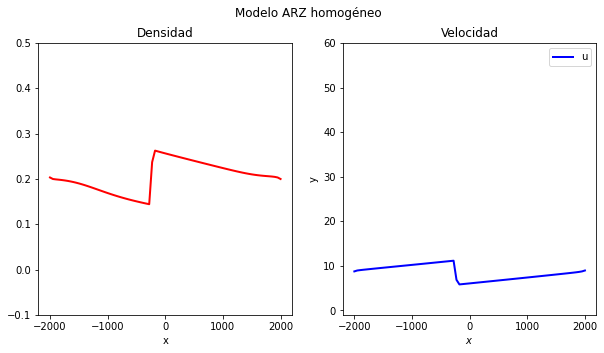

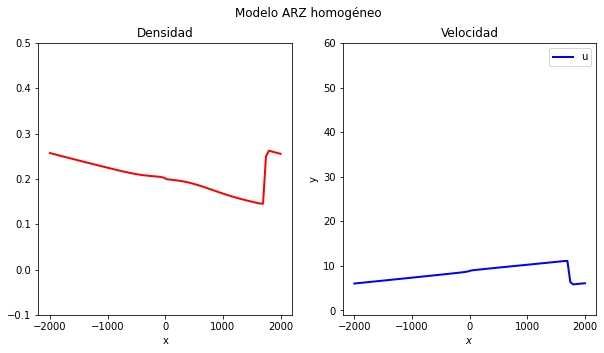

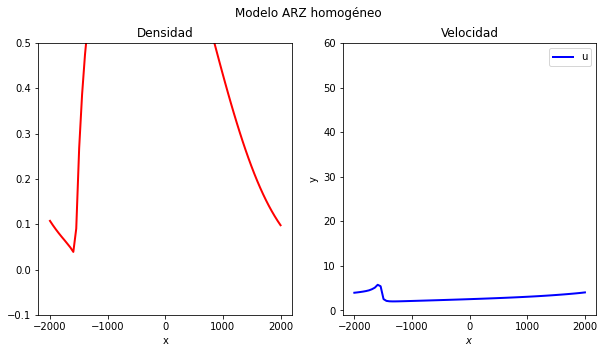

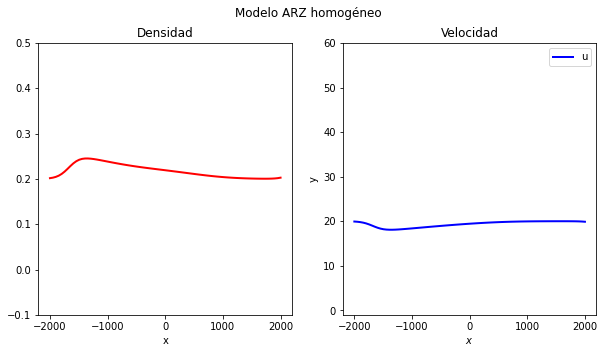

In [37]:
path = "Charts/"
Q_s = [Q_1, Q_2, Q_3, Q_4]
x_s = [x_1, x_2, x_3, x_4]

for i in range(4):
    name = "ARZ_homogeneo_Q_0_{}.gif".format(i+1)
    N_t = int(T//dt)
    get_animation(Q_s[i], x_s[i], U, N_t, "Modelo ARZ homogéneo" ,["Densidad", "Velocidad"], path+name)

In [145]:
x_4, Q_4 = godunov_ARZ(Q_0_4, dt, dx, xl, xr, T, U, tau)

No hay solución
u_r =  -2.314366934959037 demás =  -5.9630889565156
No hay solución
u_r =  -2.314366934959037 demás =  -5.9630889565156
rho negativo [-0.14110635]  n =  213
No hay solución
u_r =  1490.1981624592845 demás =  1.6081516764512447
No hay solución
u_r =  1490.1981624592845 demás =  1.6081516764512447
rho negativo [-1975.10080617]  n =  214
No hay solución
u_r =  1134.9102988154739 demás =  1.3725848394726352
No hay solución
u_r =  1134.9102988154739 demás =  1.3725848394726352
No hay solución
u_r =  -2.34978923003923 demás =  -5856129842.733705
No hay solución
u_r =  -2.34978923003923 demás =  -5856129842.733705
rho negativo [-5.34621531e+25 -9.29776020e+24]  n =  215
No hay solución
u_r =  3.629907442239292e+37 demás =  1490.453125
No hay solución
u_r =  3.629907442239292e+37 demás =  1490.453125
No hay solución
u_r =  -2.0226689599973717 demás =  -3.629926049947949e+37
No hay solución
u_r =  -2.0226689599973717 demás =  -3.629926049947949e+37
rho negativo [-7.95506047e+037

/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_51848/321938477.py:3: RuntimeWarning: invalid value encountered in sqrt
  return umax*(1-rho**gamma)
/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_51848/3163719371.py:7: RuntimeWarning: invalid value encountered in double_scalars
  output = y/rho + U(rho)
/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_51848/3681866371.py:37: RuntimeWarning: overflow encountered in double_scalars
  l_s = (rho_m * u_m - rho_l * u_l)/(rho_m - rho_l)
/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_51848/579649715.py:9: RuntimeWarning: overflow encountered in double_scalars
  return np.array([rho * u_, y * u_])
/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_51848/3163719371.py:12: RuntimeWarning: overflow encountered in double_scalars
  output = rho*(u - U(rho))
/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_51848/2508153137.py:19: RuntimeWarning: invalid value encountered in subtract
  F_[

MovieWriter ffmpeg unavailable; using Pillow instead.
/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_51848/321938477.py:3: RuntimeWarning: invalid value encountered in sqrt
  return umax*(1-rho**gamma)


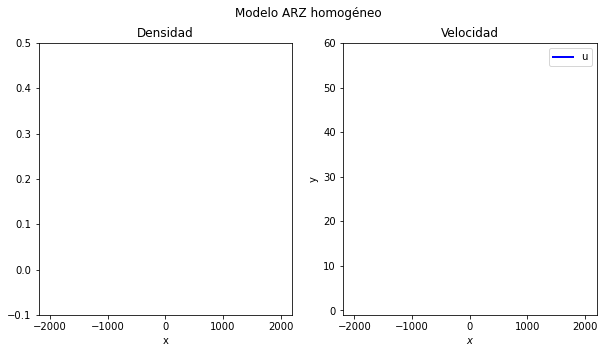

In [117]:
path = "Charts/"
name = "ARZ_homogeneo_Q_0_2_prueba.gif"
N_t = int(T//dt)
get_animation(Q_2, x_2, U, N_t, "Modelo ARZ homogéneo" ,["Densidad", "Velocidad"], path+name)

No handles with labels found to put in legend.
MovieWriter ffmpeg unavailable; using Pillow instead.


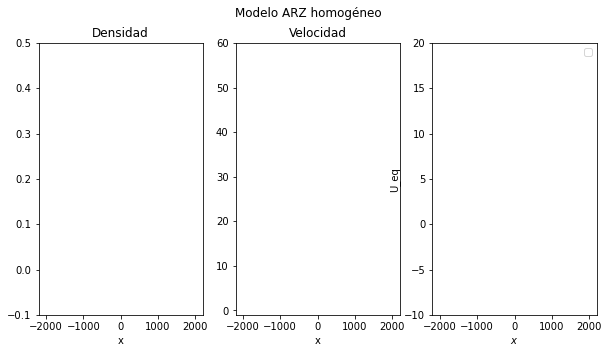

In [146]:
path = "Charts/"
name = "ARZ_homogeneo_Q_0_4_prueba.gif"
N_t = int(T//dt)
get_animation(Q_4, x_4, U, N_t, "Modelo ARZ homogéneo" ,["Densidad", "Velocidad"], path+name)

## Integral de densidad

In [135]:
def density_integral(x, dx, N_t, Q):
    integral_graph = []
    for n in range(N_t):
    
        density = Q[n, 0, :]
        integral = integrate.simpson(density, x, dx)
        integral_graph += [integral]
    
    plt.plot(integral_graph)

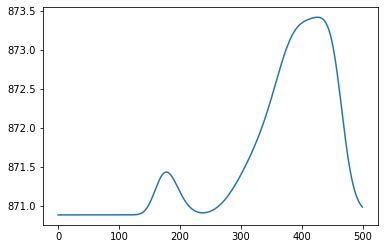

In [19]:
N_t = int(T//dt)

integral_graph = []

for n in range(N_t):
    
    rho_awa = Q_4[n, 0, :]
    integral = integrate.simpson(rho_awa, x, dx)
    integral_graph += [integral]
    #print(n, integral)

plt.plot(integral_graph)

## Mayor resolución

In [17]:
def minmod(e, dx):
    
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    # The following is inefficient but easy to read
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

In [18]:
def F_minmod(Q, N, h, l, dx):
    
    F_ = np.zeros(Q.shape)
    for i in range(1, N-1):
        
        Q_left = Q[:, i-1]
        Q_i = Q[:, i]
        Q_right = Q[:, i+1]
        
        # Slopes
        delta_minus_e = (Q_i - Q_left)/dx
        delta_plus_e = (Q_right - Q_i)/dx
        
        # Slope con minmod
        sigma_i = minmod(delta_minus_e, delta_plus_e)
        
        Q_l = Q_i - sigma_i * dx / 2
        Q_r = Q_i + sigma_i * dx / 2
        
        w_left = w(Q_l, Q_i)
        w_right = w(Q_i, Q_r)
        
        F_[:, i] = flux(w_right, h) - flux(w_left, h)
    
    return F_

* TODO: Añadir pequeña difusión para arreglar las discontinuidades
    - Elementos finitos
    - Galerkin discontinuo

## Agrega condición CFL

In [163]:
# Condición CFL
# TODO: Considerar velocidad máxima (valores propios)
def cfl(dt, dx, Q, eps=1e-2):
    rho, y = Q
    u_ = u(rho, y, U)
    
    l_max = np.max(u_)
    
    new_dt = dx/(2*l_max)
    
    #if new_dt > dt and dt != 0:
    #    return dt
    
    return new_dt

In [164]:
# Implementa Godunov
def godunov_ARZ_cfl(Q_0, dx, xl, xr, T, U, tau):
    
    # Largo de la grilla
    L = xr-xl
    
    # Numero de puntos
    N = int(L//dx)
    
    # Grilla
    x = np.linspace(xl, xr, N)
    
    # Guarda soluciones
    # Condición inicial
    Q = Q_0(x, U)
    dt = 0
    t = 0
    n = 0
    
    while t < T:
        
        # Actualiza segun condicion CFL
        dt = cfl(dt, dx, Q[n])
        l = dt/dx
        
        # Paso de Godunov
        Q_sig = Q[n] - l * F(Q[n], N, U, l)
        
        # Agrega no homogeneidad
        rho_sig, y_sig = Q_sig
        u_ = u(rho_sig, y_sig, U)
        
        # Si aparece rho negativo
        neg_rho = rho_sig[rho_sig<0]
        if len(neg_rho)>0:
            print("rho negativo", neg_rho, " n = ", n)
            rho_sig[rho_sig<0] = 1e-1
        
        # Agrega tau
        y_sig_ = y_sig * (1 - dt/(tau * rho_sig))
        Q_sig[1] = y_sig_
        
        # Condiciones de borde Periodica
        Q_sig[:, 0] = Q_sig[:, -2]
        Q_sig[:, -1] = Q_sig[:, 1]
        
        # Guarda paso
        Q_sig = np.reshape(Q_sig, (1, Q_sig.shape[0], Q_sig.shape[1]))
        Q = np.append(Q, Q_sig, axis=0)
        
        # Actualiza indice y tiempo
        n += 1
        t += dt
    print(dt)
        
    return x, Q


In [183]:
# Primera condición inicial
# Constante por pedazos
def Q_0_1_cfl(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = (0.4)*(x>=0) + 0.01*(x<0)
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = 1*(x>=0) + 30*(x<0)
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([1, 2, len(y_0)])
    Q_0_[0][0] = rho_0
    Q_0_[0][1] = y_0
    
    return Q_0_

In [197]:
# Cuarta condición inicial
# Constante por pedazos
def Q_0_4_cfl(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = np.piecewise(x, [((-1500 <= x) & (x <= -1400)), ((x>-1400) | (x<-1500))], [0.3, 0.1])
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = np.piecewise(x, [((-1500 <= x) & (x <= -1400)), ((x>-1400) | (x<-1500))], [1, 19])
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([1, 2, len(y_0)])
    Q_0_[0][0] = rho_0
    Q_0_[0][1] = y_0
    
    return Q_0_

In [193]:
# Parámetros
xl = -2000
xr = -xl
dx = 10
T = 500
tau= 2

In [186]:
x_1_cfl, Q_1_cfl = godunov_ARZ_cfl(Q_0_1_cfl, dx, xl, xr, T, U, tau)

No hay solución
u_r =  14.757822786891005 demás =  14.724344717416937
No hay solución
u_r =  49.99999999999997 demás =  19.443170935582273
No hay solución
u_r =  49.99999999999997 demás =  19.443170935582273
No hay solución
u_r =  14.757822786891005 demás =  14.724344717416937
No hay solución
u_r =  20.519418323041194 demás =  18.7486200345572
No hay solución
u_r =  20.519418323041194 demás =  18.7486200345572
No hay solución
u_r =  21.21786477076238 demás =  20.9109652517699
No hay solución
u_r =  21.21786477076238 demás =  20.9109652517699
No hay solución
u_r =  17.006531217862506 demás =  16.907299841288072
No hay solución
u_r =  17.006531217862506 demás =  16.907299841288072
No hay solución
u_r =  22.28116735204128 demás =  21.04091951793331
No hay solución
u_r =  22.28116735204128 demás =  21.04091951793331
No hay solución
u_r =  15.877703225174491 demás =  15.203861053028977
No hay solución
u_r =  15.877703225174491 demás =  15.203861053028977
No hay solución
u_r =  23.0600863855

No handles with labels found to put in legend.
MovieWriter ffmpeg unavailable; using Pillow instead.


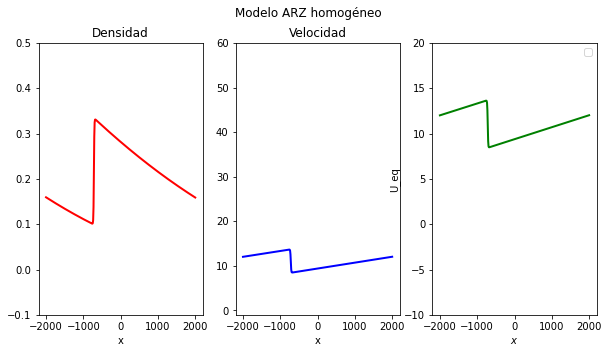

In [187]:
path = "Charts/"
name = "CFL_Q_0_1.gif"
N_t_cfl_1 = Q_1_cfl.shape[0]
get_animation(Q_1_cfl, x_1_cfl, U, N_t_cfl_1, "Modelo ARZ homogéneo" ,["Densidad", "Velocidad"], path+name)

In [198]:
x_4_cfl, Q_4_cfl = godunov_ARZ_cfl(Q_0_4_cfl, dx, xl, xr, T, U, tau)

No hay solución
u_r =  19.0 demás =  11.95445115010332
No hay solución
u_r =  19.0 demás =  11.95445115010332
0.3656188238935662


No handles with labels found to put in legend.
MovieWriter ffmpeg unavailable; using Pillow instead.


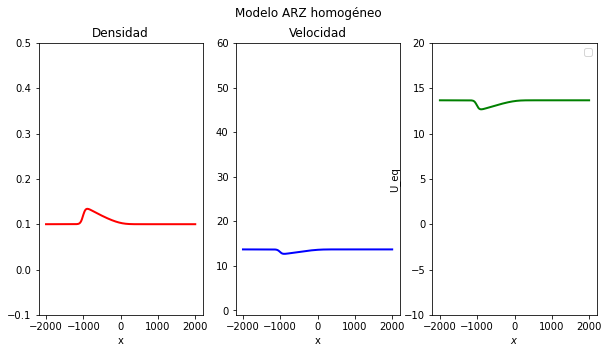

In [199]:
path = "Charts/"
name = "CFL_Q_0_4.gif"
N_t_cfl_4 = Q_4_cfl.shape[0]
get_animation(Q_4_cfl, x_4_cfl, U, N_t_cfl_4, "Modelo ARZ homogéneo" ,["Densidad", "Velocidad"], path+name)

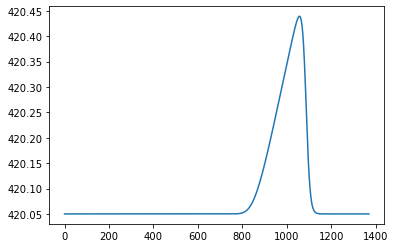

In [200]:
density_integral(x_4_cfl, dx, N_t_cfl_4, Q_4_cfl)